# 2. Using the API to obtain basic statistics about Rotterdam University 

This Notebook shows how it's possible to extract basic indicators about Rotterdam University programmatically, using the Dimensions API with Jupyter Notebooks. 


In [1]:
import dimcli
from dimcli.shortcuts import dslquery
import pandas as pd
from pandas.io.json import json_normalize
import plotly_express as px

#####  First let's find the ID for Rotterdam University

In [2]:
dslquery("""search publications where research_orgs.name="Rotterdam" return research_orgs""").as_dataframe().head()

acronym  count country_name             id  \
0     EUR  28077  Netherlands    grid.6906.9   
1     NaN   2008  Netherlands    grid.5645.2   
2     NaN    852  Netherlands    grid.5477.1   
3     NaN    785  Netherlands  grid.414699.7   
4      VU    736  Netherlands  grid.12380.38   

                                name  
0       Erasmus University Rotterdam  
1  Erasmus University Medical Center  
2                 Utrecht University  
3             Rotterdam Eye Hospital  
4            VU University Amsterdam

In [3]:
GRIDID = "grid.6906.9"

# 1. Publications

## Publications output by year 

In [4]:
dslquery(f"""search publications where research_orgs.id="{GRIDID}" return publications""").stats 

{'total_count': 28077}

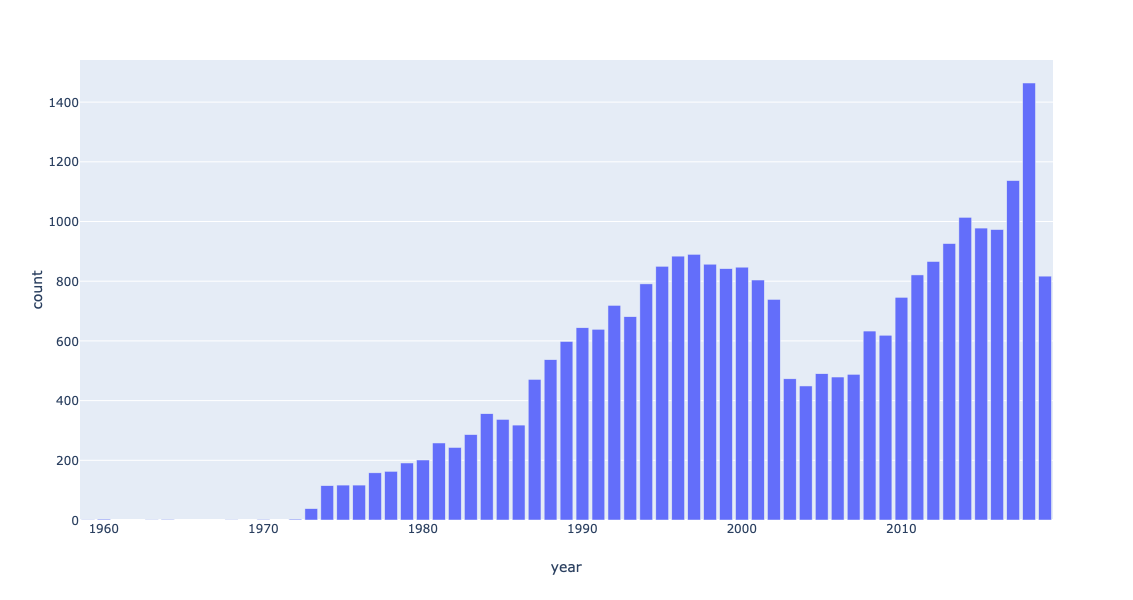

In [5]:
df = dslquery("""search publications where research_orgs.id="grid.6906.9" return year limit 100""").as_dataframe() 
df.rename(columns={"id": "year"}, inplace=True)
px.bar(df, x="year", y="count")

## Publications most cited in last 2 years

In [6]:
data = dslquery(f"""search publications where research_orgs.id="{GRIDID}" return publications[doi+title+recent_citations+FOR+journal] sort by recent_citations""")
df = json_normalize(data.publications)
df.head(10)[['title', 'doi', 'recent_citations', 'journal.title']]

title  \
0  The Job Demands‐Resources model: state of the art   
1                 Colorectal cancer statistics, 2017   
2  EQ-SD: a measure of health status from the Eur...   
3  Software survey: VOSviewer, a computer program...   
4                                    Inside the Turk   
5  Optimization and Approximation in Deterministi...   
6  Entrepreneurial Orientation and Business Perfo...   
7  Business models for sustainable innovation: st...   
8  The multidimensional Fatigue Inventory (MFI) p...   
9  Genome-wide association study identifies 74 lo...   

                                doi  recent_citations  \
0         10.1108/02683940710733115              1234   
1                10.3322/caac.21395               996   
2         10.3109/07853890109002087               703   
3         10.1007/s11192-009-0146-3               595   
4          10.1177/0963721414531598               590   
5     10.1016/s0167-5060(08)70356-x               555   
6  10.1111/j.1540-6520.2009.00308.x               452   
7     10.1016/j.jclepro.2012.07.007               421   
8      10.1016/0022-3999(94)00125-o               381   
9               10.1038/nature17671               366   

                                 journal.title  
0             Journal of Managerial Psychology  
1           CA A Cancer Journal for Clinicians  
2                           Annals of Medicine  
3                               Scientometrics  
4  Current Directions in Psychological Science  
5                                          NaN  
6         Entrepreneurship Theory and Practice  
7                Journal of Cleaner Production  
8            Journal of Psychosomatic Research  
9                                       Nature

## Publications most cited - all time

In [7]:
data = dslquery(f"""search publications where research_orgs.id="{GRIDID}" return publications[doi+title+times_cited+FOR+journal] sort by times_cited limit 1000""")
df = json_normalize(data.publications)
df.head(10)[['title', 'doi', 'times_cited', 'journal.title']]

title  \
0  Optimization and Approximation in Deterministi...   
1  The Job Demands‐Resources model: state of the art   
2  Genome maintenance mechanisms for preventing c...   
3  Identification of a gene (FMR-1) containing a ...   
4  Association of missense and 5′-splice-site mut...   
5  Randomised double-blind comparison of placebo ...   
6  EQ-SD: a measure of health status from the Eur...   
7  A new variant of Creutzfeldt-Jakob disease in ...   
8  Identification of a Novel Coronavirus in Patie...   
9  Familial Hemiplegic Migraine and Episodic Atax...   

                             doi  times_cited  \
0  10.1016/s0167-5060(08)70356-x         3228   
1      10.1108/02683940710733115         2591   
2               10.1038/35077232         2590   
3   10.1016/0092-8674(91)90397-h         2405   
4                  10.1038/31508         2348   
5  10.1016/s0140-6736(97)05381-6         2290   
6      10.3109/07853890109002087         2172   
7  10.1016/s0140-6736(96)91412-9         1957   
8           10.1056/nejmoa030747         1808   
9  10.1016/s0092-8674(00)81373-2         1749   

                      journal.title  
0                               NaN  
1  Journal of Managerial Psychology  
2                            Nature  
3                              Cell  
4                            Nature  
5                        The Lancet  
6                Annals of Medicine  
7                        The Lancet  
8   New England Journal of Medicine  
9                              Cell

## Publications most cited : which research areas?

First we want to ensure all publications have a valid FOR code key. Also, we want to break them up cause each publication can have more than one. 
The FOR structure for a single publication is like this: `{'FOR' : [{'id': '3292', 'name': '1402 Applied Economics'}, {'id': '3177', 'name': '1117 Public Health and Health Services'}]}`

In [8]:
data = dslquery(f"""search publications where research_orgs.id="{GRIDID}" return publications[doi+title+times_cited+FOR+journal] sort by times_cited limit 1000""")
for x in data.publications:
    if not 'FOR' in x:
        x['FOR'] = ""
    else:
        x['FOR'] = [{'name' : x['name'][5:]} for x in x['FOR']] # also remove the digit prefix to improve legibility

In [9]:
df = json_normalize(data.publications, record_path='FOR', meta=['doi', 'title', 'times_cited', ['journal', 'title']], errors='ignore' )
df.head()

name                            doi  \
0  Numerical and Computational Mathematics  10.1016/s0167-5060(08)70356-x   
1                  Business and Management      10.1108/02683940710733115   
2                                 Genetics               10.1038/35077232   
3                                 Genetics   10.1016/0092-8674(91)90397-h   
4                                 Genetics                  10.1038/31508   

                                               title  times_cited  \
0  Optimization and Approximation in Deterministi...         3228   
1  The Job Demands‐Resources model: state of the art         2591   
2  Genome maintenance mechanisms for preventing c...         2590   
3  Identification of a gene (FMR-1) containing a ...         2405   
4  Association of missense and 5′-splice-site mut...         2348   

                      journal.title  
0                               nan  
1  Journal of Managerial Psychology  
2                            Nature  
3                              Cell  
4                            Nature

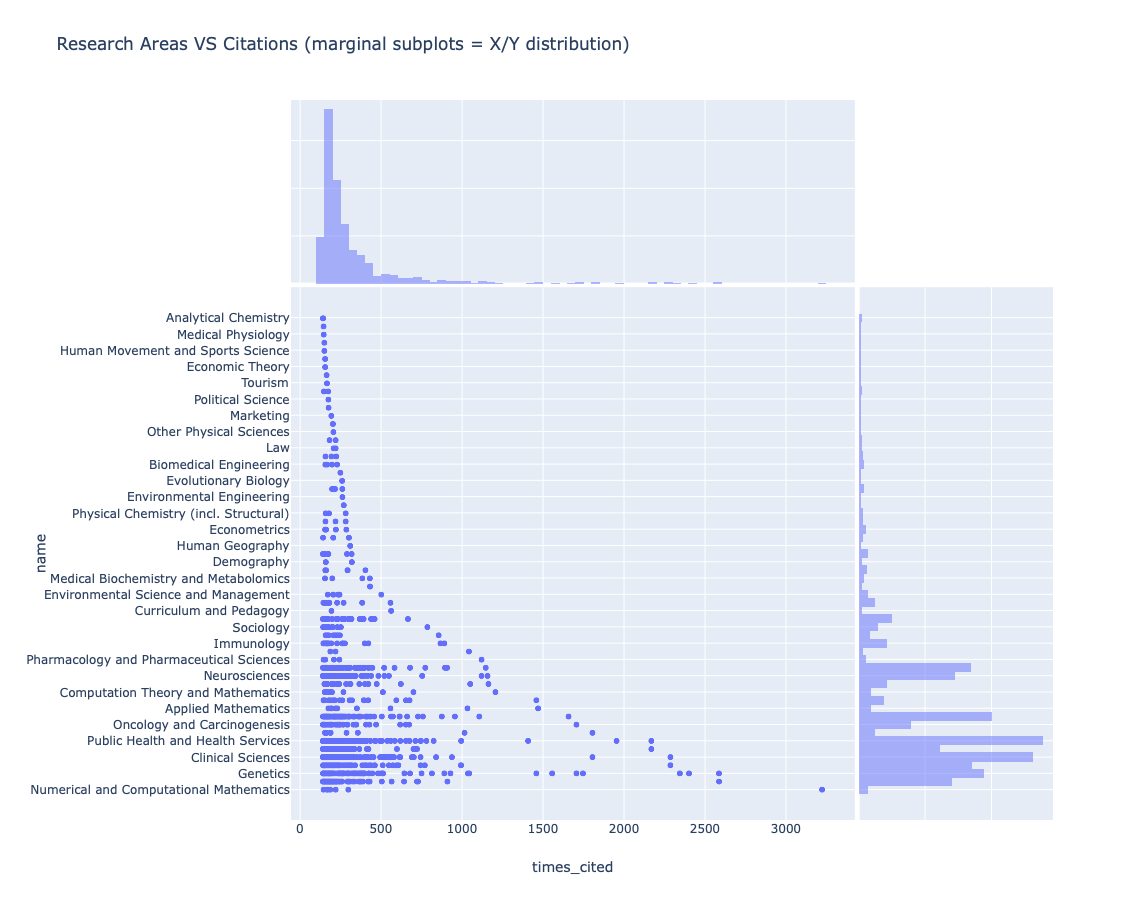

In [10]:
px.scatter(df, x="times_cited", y="name", marginal_x="histogram", marginal_y="histogram", height=900, title="Research Areas VS Citations (marginal subplots = X/Y distribution)")

## Publications most cited : which journals?

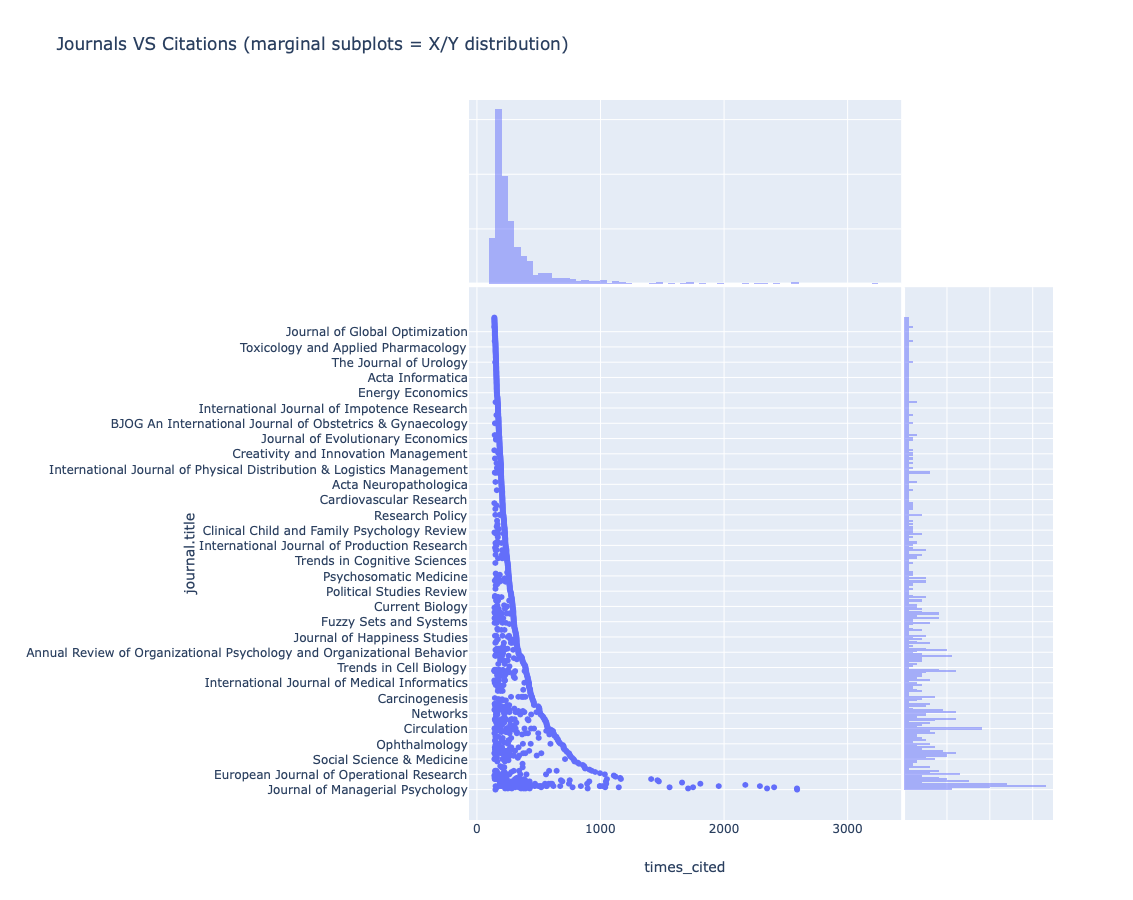

In [11]:
data2 = dslquery(f"""search publications where research_orgs.id="{GRIDID}" return publications[doi+title+times_cited+FOR+journal] sort by times_cited limit 1000""")
df2 = json_normalize(data2.publications)
px.scatter(df2, x="times_cited", y="journal.title", marginal_x="histogram", marginal_y="histogram", height=900, title="Journals VS Citations (marginal subplots = X/Y distribution)")

## Combining the previous two charts ...

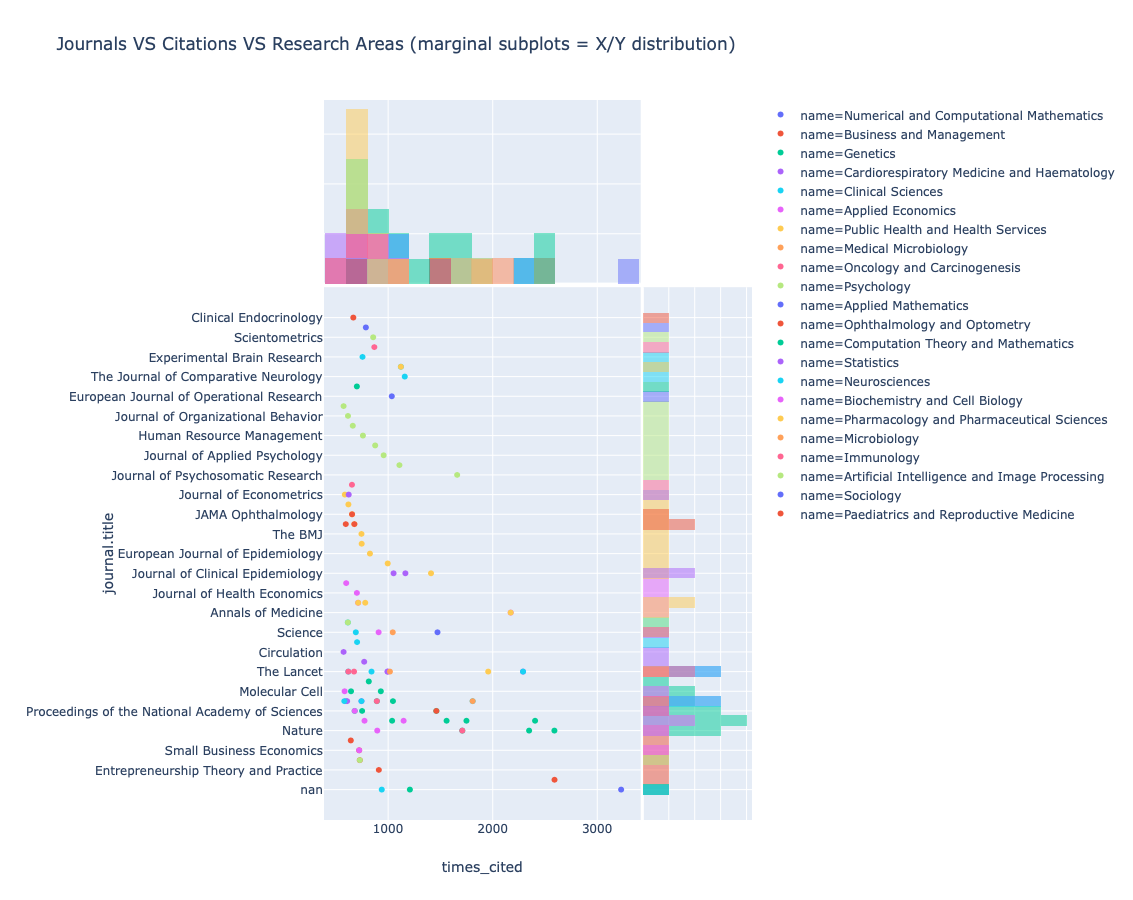

In [12]:
px.scatter(df.head(100), x="times_cited", y="journal.title", color="name", marginal_x="histogram", marginal_y="histogram", height=900, title="Journals VS Citations VS Research Areas (marginal subplots = X/Y distribution)")

# 2. Funding

## Top Funders for Rotterdam (by aggregated funding amount)

In [13]:
fundersdata = dslquery(f"""search grants where research_orgs.id="{GRIDID}" return funders aggregate funding sort by funding""")
df = fundersdata.as_dataframe()
df.head(10)

acronym  count    country_name      funding             id  \
0      EC    352         Belgium  661484061.0  grid.270680.b   
1     MRC     38  United Kingdom  158741793.0  grid.14105.31   
2     ERC     11         Belgium   19992223.0  grid.452896.4   
3     NWO    699     Netherlands   14727593.0  grid.420488.2   
4   EPSRC      5  United Kingdom    8627609.0  grid.421091.f   
5    ESRC      9  United Kingdom    7567434.0  grid.434257.3   
6    AICR     13  United Kingdom    3643649.0  grid.453093.8   
7   BBSRC      4  United Kingdom    2863256.0  grid.418100.c   
8    AHRC      1  United Kingdom    2685118.0  grid.426413.6   
9     ARC      9       Australia    2221700.0  grid.413452.5   

                                                name  
0                                European Commission  
1                           Medical Research Council  
2                          European Research Council  
3   Netherlands Organisation for Scientific Research  
4  Engineering and Physical Sciences Research Cou...  
5               Economic and Social Research Council  
6                          Worldwide Cancer Research  
7  Biotechnology and Biological Sciences Research...  
8               Arts and Humanities Research Council  
9                        Australian Research Council

## Top funders split by country of the funder

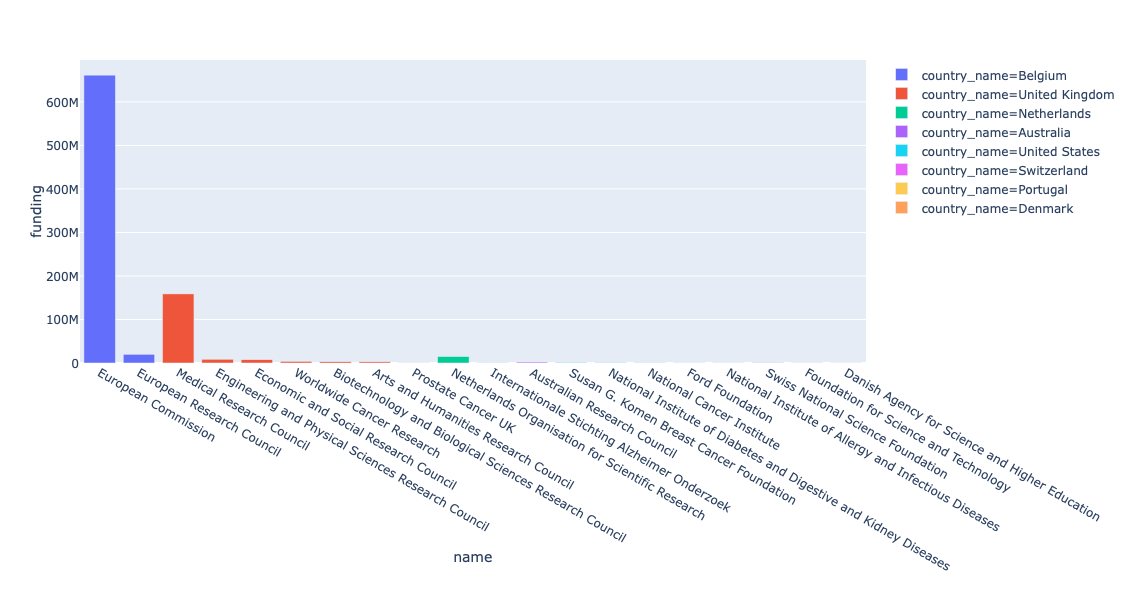

In [14]:
px.bar(df, x="name", y="funding", color="country_name")

## Correlation between No of Publications VS Funding

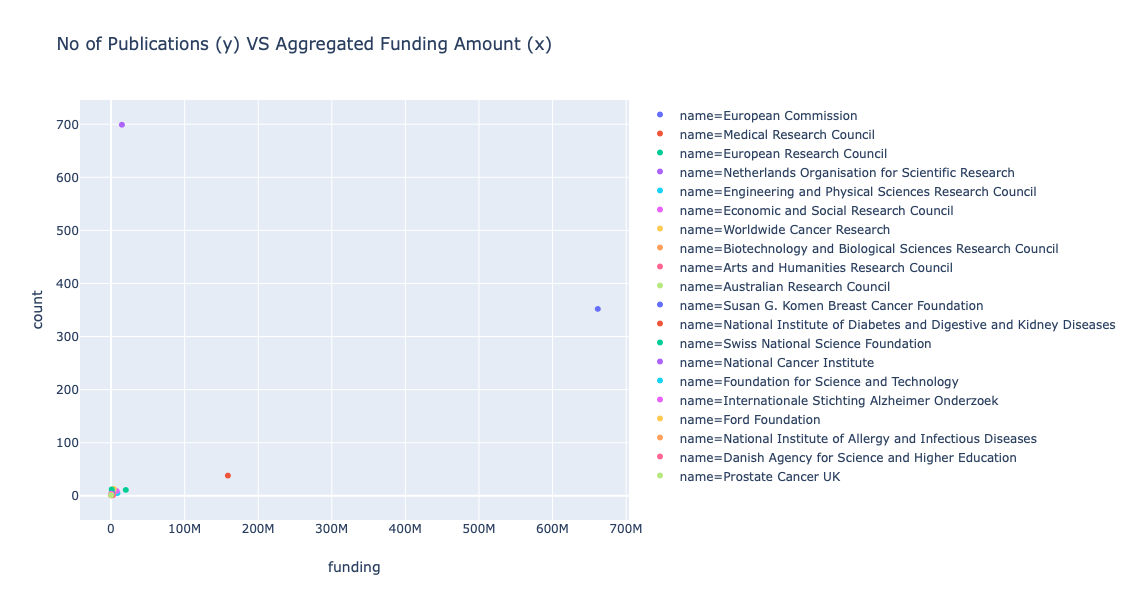

In [15]:
px.scatter(df, x="funding", y="count", color="name", title="No of Publications (y) VS Aggregated Funding Amount (x)")